In [ ]:
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir
! pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-tuogop8p
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-tuogop8p
  Resolved https://github.com/albu/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=f085e4cd7144032c81aac6650ad7c9194ec269ac3d8c70998256a1b9e7c94790
  Stored in directory: /tmp/pip-ephem-wheel-cache-c29i8_st/wheels/3c/df/16/b3d0d64428c9f25b1ab03989a2e574546d3336647946d31e56
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, h

In [ ]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import StepLR, OneCycleLR
%matplotlib inline

# Dataset and Creating Train/Test Split

In [ ]:
def get_stats(trainloader):
  """
  Args:
      trainloader (trainloader): Original data with no preprocessing
  Returns:
      mean: per channel mean
      std: per channel std
  """
  train_data = trainloader.dataset.data

  print('[Train]')
  print(' - Numpy Shape:', train_data.shape)
  print(' - Tensor Shape:', train_data.shape)
  print(' - min:', np.min(train_data))
  print(' - max:', np.max(train_data))

  train_data = train_data / 255.0

  mean = np.mean(train_data, axis=tuple(range(train_data.ndim-1)))
  std = np.std(train_data, axis=tuple(range(train_data.ndim-1)))

  print(f'\nDataset Mean - {mean}')
  print(f'Dataset Std - {std} ')

  return([mean, std])


def get_loader(transform=None, train=True):
  """
  Args:
      transform (transform): Albumentations transform
  Returns:
      loader: DataLoader Object
  """
  if transform:
    trainset = Cifar10SearchDataset(transform=transform)
  else:
    trainset = Cifar10SearchDataset(root="~/data/cifar10", train=train,
                                    download=True)
  loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                       shuffle=train, num_workers=2)
  return(loader)


def get_summary(model, device):
  """
  Args:
      model (torch.nn Model): Original data with no preprocessing
      device (str): cuda/CPU
  """
  print(summary(model, input_size=(3, 32, 32)))



def get_device():
  """
  Returns:
      device (str): device type
  """
  SEED = 1

  # CUDA?
  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  # For reproducibility
  if cuda:
      torch.cuda.manual_seed(SEED)
  else:
    torch.manual_seed(SEED)

  return(device)

In [ ]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


def get_train_transform(mu, sigma):

    """
    Args:
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
    Returns:
        Tensor: Normalized image.
    """
    train_transform = A.Compose([
                             A.HorizontalFlip(p=0.4),
                             A.ShiftScaleRotate(),
                             A.Normalize(mean=(mu),
                                         std=(sigma)),
                             A.CoarseDropout(max_holes=1,
                                             max_height=8,
                                             max_width=8,
                                             min_holes=1,
                                             min_height=8,
                                             min_width=8,
                                             fill_value=(mu)),
                             A.ToGray(),
                             ToTensorV2(),
])

    return(train_transform)



def get_test_transform(mu, sigma):
    """
    Args:
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
    Returns:
        Tensor: Normalized image.
        """
    test_transform = A.Compose([
                            A.Normalize(
                                mean=(mu),
                                std=(sigma)),
                            ToTensorV2(),
])
    return(test_transform)


def no_transform():
    return(A.Compose([A.Normalize()]))

In [ ]:
trainloader = get_loader(transform=None)
mean, std = get_stats(trainloader)
denorm = UnNormalize(mean, std)

100%|██████████| 170498071/170498071 [00:01<00:00, 100506006.74it/s]


Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: (50000, 32, 32, 3)
 - min: 0
 - max: 255

Dataset Mean - [0.49139968 0.48215841 0.44653091]
Dataset Std - [0.24703223 0.24348513 0.26158784] 


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
train_transform = get_train_transform(mean, std)
test_transform = get_test_transform(mean, std)

In [ ]:
trainloader = get_loader(transform=train_transform)
testloader = get_loader(transform=test_transform, train=False)

Files already downloaded and verified
Files already downloaded and verified


plane  deer truck truck


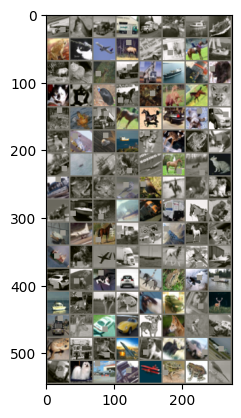

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = denorm(img)    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
device = get_device()

CUDA Available? True


# The model

In [ ]:
dropout_value = 0.04

def norm_layer(norm_type, dimensions):
    if norm_type == "BN":
        return(nn.BatchNorm2d(dimensions[0]))
    elif norm_type == "LN":
        return(nn.LayerNorm(dimensions, elementwise_affine=False))
    elif norm_type == "GN":
        return nn.GroupNorm(dimensions[0]//2, dimensions[0])
    else:
        raise ValueError('Options are BN / LN / GN')

class Net(nn.Module):
    def __init__(self, norm="BN"):
        super(Net, self).__init__()
        self.norm = norm

        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            norm_layer(self.norm, [32, 32, 32]),
            nn.Dropout(dropout_value),
        ) # output_size = 32
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            norm_layer(self.norm, [16, 32, 32]),
            nn.Dropout(dropout_value),
        ) # output_size = 32

        # TRANSITION BLOCK 1
        self.transblock1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, stride=2, bias=False),
        ) # output_size = 16


        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            norm_layer(self.norm, [16, 16, 16]),
            nn.Dropout(dropout_value),


        ) # output_size = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            norm_layer(self.norm, [16, 16, 16]),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            norm_layer(self.norm, [16, 16, 16]),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # TRANSITION BLOCK 2
        self.transblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=2, bias=False),
        ) # output_size = 8

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            norm_layer(self.norm, [32, 8, 8]),
            nn.Dropout(dropout_value),
        ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            norm_layer(self.norm, [16, 8, 8]),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            norm_layer(self.norm, [16, 8, 8]),
            nn.Dropout(dropout_value),
        ) # output_size = 8

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.skip_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.skip_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.downsample1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, stride=2, bias=False),
        )

        self.downsample2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, stride=2, bias=False),
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x) # 3x32x32 -> 32x32x32
        x_clone = self.downsample1(x.clone()) # 32x32x32 -> 32x16x16

        x = self.convblock2(x) # 32x32x32 -> 16x32x32
        x = self.transblock1(x) # 16x16x16

        x = self.convblock3(x) # 16x16x16
        x_clone2 = self.downsample2(x.clone()) # 32x8x8

        x = x_clone + x #16x16x16


        x = self.convblock4(x) # 16x16x16
        x = self.transblock2(x) # 32x8x8

        x = self.convblock5(x) # 32x8x8
        x = x_clone2 + x # 32x8x8

        x = self.convblock6(x) # 16x8x8
        x = self.convblock7(x)

        x = self.gap(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
model = Net().to(device)
get_summary(model, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 16, 16, 16]             512
            Conv2d-6           [-1, 16, 32, 32]           4,608
              ReLU-7           [-1, 16, 32, 32]               0
       BatchNorm2d-8           [-1, 16, 32, 32]              32
           Dropout-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]             512
           Conv2d-11           [-1, 16, 16, 16]           4,608
           Conv2d-12           [-1, 16, 16, 16]           2,304
             ReLU-13           [-1, 16, 16, 16]               0
      BatchNorm2d-14           [-1, 16,

# Training and Testing
Looking at logs can be boring, so we'll introduce tqdm progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

lambda_1 = 0.01


def train(model, device, train_loader, optimizer, epoch, L1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # if using L1 regularization
    l1 = 1 if L1 else 0

    if l1:
      for p in model.parameters():
        l1 += torch.norm(p)

    loss += lambda_1 * l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our models


In [ ]:
norm_options = ["BN", "GN", "LN"]

metrics = {}

for norm in norm_options:
  model = Net(norm).to(device)
  print(f"Norm Type - { norm }")

  # print summary for norm type
  summary(model, input_size=(3, 32, 32))

  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  lambda_1 = 0.01

  EPOCHS = 20

  model =  Net(norm).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=8, gamma=0.1)


  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)

      # use L1 if norm is BN
      L1 = 1 if norm == "BN" else 0

      train(model, device, trainloader, optimizer, epoch, L1=L1)
      scheduler.step()
      test(model, device, testloader)


  metrics[norm] = [train_losses, test_losses, train_acc, test_acc]



Norm Type - BN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 16, 16, 16]             512
            Conv2d-6           [-1, 16, 32, 32]           4,608
              ReLU-7           [-1, 16, 32, 32]               0
       BatchNorm2d-8           [-1, 16, 32, 32]              32
           Dropout-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]             512
           Conv2d-11           [-1, 16, 16, 16]           4,608
           Conv2d-12           [-1, 16, 16, 16]           2,304
             ReLU-13           [-1, 16, 16, 16]               0
      BatchNorm2d-14    

Loss=2.6463892459869385 Batch_id=390 Accuracy=26.91: 100%|██████████| 391/391 [00:16<00:00, 23.57it/s]



Test set: Average loss: 1.5886, Accuracy: 19971/50000 (39.94%)

EPOCH: 1


Loss=2.1989693641662598 Batch_id=390 Accuracy=40.15: 100%|██████████| 391/391 [00:15<00:00, 24.92it/s]



Test set: Average loss: 1.5293, Accuracy: 22111/50000 (44.22%)

EPOCH: 2


Loss=2.2397871017456055 Batch_id=390 Accuracy=45.11: 100%|██████████| 391/391 [00:16<00:00, 24.37it/s]



Test set: Average loss: 1.3015, Accuracy: 25894/50000 (51.79%)

EPOCH: 3


Loss=2.19765305519104 Batch_id=390 Accuracy=48.35: 100%|██████████| 391/391 [00:15<00:00, 24.48it/s]



Test set: Average loss: 1.3254, Accuracy: 26907/50000 (53.81%)

EPOCH: 4


Loss=2.114284038543701 Batch_id=390 Accuracy=50.65: 100%|██████████| 391/391 [00:16<00:00, 24.41it/s]



Test set: Average loss: 1.1827, Accuracy: 28468/50000 (56.94%)

EPOCH: 5


Loss=1.759634256362915 Batch_id=390 Accuracy=52.53: 100%|██████████| 391/391 [00:15<00:00, 25.61it/s]



Test set: Average loss: 1.0796, Accuracy: 30797/50000 (61.59%)

EPOCH: 6


Loss=1.9324307441711426 Batch_id=390 Accuracy=53.57: 100%|██████████| 391/391 [00:16<00:00, 23.66it/s]



Test set: Average loss: 1.0638, Accuracy: 30819/50000 (61.64%)

EPOCH: 7


Loss=1.8804428577423096 Batch_id=390 Accuracy=54.42: 100%|██████████| 391/391 [00:15<00:00, 24.77it/s]



Test set: Average loss: 1.0481, Accuracy: 31056/50000 (62.11%)

EPOCH: 8


Loss=1.672952651977539 Batch_id=390 Accuracy=58.89: 100%|██████████| 391/391 [00:16<00:00, 23.52it/s]



Test set: Average loss: 0.8929, Accuracy: 34100/50000 (68.20%)

EPOCH: 9


Loss=1.8482751846313477 Batch_id=390 Accuracy=60.28: 100%|██████████| 391/391 [00:16<00:00, 24.38it/s]



Test set: Average loss: 0.8640, Accuracy: 34556/50000 (69.11%)

EPOCH: 10


Loss=1.6924724578857422 Batch_id=390 Accuracy=60.35: 100%|██████████| 391/391 [00:16<00:00, 24.37it/s]



Test set: Average loss: 0.8520, Accuracy: 34727/50000 (69.45%)

EPOCH: 11


Loss=1.378498911857605 Batch_id=390 Accuracy=60.87: 100%|██████████| 391/391 [00:15<00:00, 24.77it/s]



Test set: Average loss: 0.8382, Accuracy: 35011/50000 (70.02%)

EPOCH: 12


Loss=1.4964830875396729 Batch_id=390 Accuracy=61.25: 100%|██████████| 391/391 [00:16<00:00, 23.72it/s]



Test set: Average loss: 0.8242, Accuracy: 35269/50000 (70.54%)

EPOCH: 13


Loss=1.8833591938018799 Batch_id=390 Accuracy=61.31: 100%|██████████| 391/391 [00:15<00:00, 24.99it/s]



Test set: Average loss: 0.8404, Accuracy: 34847/50000 (69.69%)

EPOCH: 14


Loss=1.2433743476867676 Batch_id=390 Accuracy=61.51: 100%|██████████| 391/391 [00:15<00:00, 24.72it/s]



Test set: Average loss: 0.8092, Accuracy: 35572/50000 (71.14%)

EPOCH: 15


Loss=1.4147238731384277 Batch_id=390 Accuracy=61.67: 100%|██████████| 391/391 [00:15<00:00, 24.78it/s]



Test set: Average loss: 0.8233, Accuracy: 35156/50000 (70.31%)

EPOCH: 16


Loss=1.4325501918792725 Batch_id=390 Accuracy=62.62: 100%|██████████| 391/391 [00:15<00:00, 24.67it/s]



Test set: Average loss: 0.7871, Accuracy: 35897/50000 (71.79%)

EPOCH: 17


Loss=1.408717393875122 Batch_id=390 Accuracy=62.86: 100%|██████████| 391/391 [00:16<00:00, 23.36it/s]



Test set: Average loss: 0.7804, Accuracy: 36030/50000 (72.06%)

EPOCH: 18


Loss=1.6580168008804321 Batch_id=390 Accuracy=62.69: 100%|██████████| 391/391 [00:16<00:00, 24.31it/s]



Test set: Average loss: 0.7794, Accuracy: 36051/50000 (72.10%)

EPOCH: 19


Loss=1.4961715936660767 Batch_id=390 Accuracy=62.80: 100%|██████████| 391/391 [00:15<00:00, 25.16it/s]



Test set: Average loss: 0.7793, Accuracy: 36035/50000 (72.07%)

Norm Type - GN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
         GroupNorm-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 16, 16, 16]             512
            Conv2d-6           [-1, 16, 32, 32]           4,608
              ReLU-7           [-1, 16, 32, 32]               0
         GroupNorm-8           [-1, 16, 32, 32]              32
           Dropout-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]             512
           Conv2d-11           [-1, 16, 16, 16]           4,608
           Conv2d-12           [-1, 16, 16, 16]           2,304
             ReLU-13   

Loss=1.8293908834457397 Batch_id=390 Accuracy=20.06: 100%|██████████| 391/391 [00:14<00:00, 27.48it/s]



Test set: Average loss: 1.7547, Accuracy: 15183/50000 (30.37%)

EPOCH: 1


Loss=1.5408668518066406 Batch_id=390 Accuracy=35.03: 100%|██████████| 391/391 [00:14<00:00, 27.00it/s]



Test set: Average loss: 1.4402, Accuracy: 23773/50000 (47.55%)

EPOCH: 2


Loss=1.3355013132095337 Batch_id=390 Accuracy=42.55: 100%|██████████| 391/391 [00:13<00:00, 28.12it/s]



Test set: Average loss: 1.3066, Accuracy: 26011/50000 (52.02%)

EPOCH: 3


Loss=1.5111348628997803 Batch_id=390 Accuracy=45.99: 100%|██████████| 391/391 [00:14<00:00, 26.51it/s]



Test set: Average loss: 1.2231, Accuracy: 27984/50000 (55.97%)

EPOCH: 4


Loss=1.175372838973999 Batch_id=390 Accuracy=49.26: 100%|██████████| 391/391 [00:14<00:00, 26.91it/s]



Test set: Average loss: 1.1111, Accuracy: 30188/50000 (60.38%)

EPOCH: 5


Loss=1.38468337059021 Batch_id=390 Accuracy=51.37: 100%|██████████| 391/391 [00:14<00:00, 27.79it/s]



Test set: Average loss: 1.0945, Accuracy: 30444/50000 (60.89%)

EPOCH: 6


Loss=1.1186678409576416 Batch_id=390 Accuracy=53.13: 100%|██████████| 391/391 [00:13<00:00, 28.12it/s]



Test set: Average loss: 1.0220, Accuracy: 31703/50000 (63.41%)

EPOCH: 7


Loss=1.3760664463043213 Batch_id=390 Accuracy=54.75: 100%|██████████| 391/391 [00:14<00:00, 27.12it/s]



Test set: Average loss: 1.0010, Accuracy: 31837/50000 (63.67%)

EPOCH: 8


Loss=0.9603184461593628 Batch_id=390 Accuracy=58.34: 100%|██████████| 391/391 [00:14<00:00, 27.82it/s]



Test set: Average loss: 0.9040, Accuracy: 33863/50000 (67.73%)

EPOCH: 9


Loss=1.1761972904205322 Batch_id=390 Accuracy=59.32: 100%|██████████| 391/391 [00:14<00:00, 27.91it/s]



Test set: Average loss: 0.8846, Accuracy: 34227/50000 (68.45%)

EPOCH: 10


Loss=1.2932533025741577 Batch_id=390 Accuracy=59.60: 100%|██████████| 391/391 [00:14<00:00, 27.87it/s]



Test set: Average loss: 0.8766, Accuracy: 34359/50000 (68.72%)

EPOCH: 11


Loss=1.1677533388137817 Batch_id=390 Accuracy=60.01: 100%|██████████| 391/391 [00:14<00:00, 27.85it/s]



Test set: Average loss: 0.8724, Accuracy: 34412/50000 (68.82%)

EPOCH: 12


Loss=0.9060704112052917 Batch_id=390 Accuracy=60.22: 100%|██████████| 391/391 [00:14<00:00, 26.31it/s]



Test set: Average loss: 0.8707, Accuracy: 34525/50000 (69.05%)

EPOCH: 13


Loss=1.212816596031189 Batch_id=390 Accuracy=60.25: 100%|██████████| 391/391 [00:14<00:00, 27.61it/s]



Test set: Average loss: 0.8556, Accuracy: 34848/50000 (69.70%)

EPOCH: 14


Loss=1.1897636651992798 Batch_id=390 Accuracy=60.66: 100%|██████████| 391/391 [00:14<00:00, 27.01it/s]



Test set: Average loss: 0.8523, Accuracy: 34914/50000 (69.83%)

EPOCH: 15


Loss=0.9808737635612488 Batch_id=390 Accuracy=60.83: 100%|██████████| 391/391 [00:14<00:00, 27.25it/s]



Test set: Average loss: 0.8438, Accuracy: 35018/50000 (70.04%)

EPOCH: 16


Loss=1.0123904943466187 Batch_id=390 Accuracy=61.22: 100%|██████████| 391/391 [00:14<00:00, 27.50it/s]



Test set: Average loss: 0.8377, Accuracy: 35126/50000 (70.25%)

EPOCH: 17


Loss=1.0154211521148682 Batch_id=390 Accuracy=61.31: 100%|██████████| 391/391 [00:13<00:00, 27.99it/s]



Test set: Average loss: 0.8339, Accuracy: 35180/50000 (70.36%)

EPOCH: 18


Loss=1.2317339181900024 Batch_id=390 Accuracy=61.50: 100%|██████████| 391/391 [00:14<00:00, 27.92it/s]



Test set: Average loss: 0.8332, Accuracy: 35172/50000 (70.34%)

EPOCH: 19


Loss=1.0425753593444824 Batch_id=390 Accuracy=61.21: 100%|██████████| 391/391 [00:14<00:00, 27.79it/s]



Test set: Average loss: 0.8321, Accuracy: 35231/50000 (70.46%)

Norm Type - LN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
         LayerNorm-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 16, 16, 16]             512
            Conv2d-6           [-1, 16, 32, 32]           4,608
              ReLU-7           [-1, 16, 32, 32]               0
         LayerNorm-8           [-1, 16, 32, 32]               0
           Dropout-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]             512
           Conv2d-11           [-1, 16, 16, 16]           4,608
           Conv2d-12           [-1, 16, 16, 16]           2,304
             ReLU-13   

Loss=1.7742105722427368 Batch_id=390 Accuracy=22.73: 100%|██████████| 391/391 [00:14<00:00, 26.85it/s]



Test set: Average loss: 1.6581, Accuracy: 18329/50000 (36.66%)

EPOCH: 1


Loss=1.462463617324829 Batch_id=390 Accuracy=35.84: 100%|██████████| 391/391 [00:13<00:00, 28.38it/s]



Test set: Average loss: 1.4361, Accuracy: 22923/50000 (45.85%)

EPOCH: 2


Loss=1.5130267143249512 Batch_id=390 Accuracy=43.26: 100%|██████████| 391/391 [00:13<00:00, 28.01it/s]



Test set: Average loss: 1.3049, Accuracy: 26137/50000 (52.27%)

EPOCH: 3


Loss=1.3677538633346558 Batch_id=390 Accuracy=47.81: 100%|██████████| 391/391 [00:13<00:00, 29.16it/s]



Test set: Average loss: 1.1611, Accuracy: 29056/50000 (58.11%)

EPOCH: 4


Loss=1.3318980932235718 Batch_id=390 Accuracy=51.09: 100%|██████████| 391/391 [00:14<00:00, 27.57it/s]



Test set: Average loss: 1.1016, Accuracy: 30031/50000 (60.06%)

EPOCH: 5


Loss=1.2216260433197021 Batch_id=390 Accuracy=52.50: 100%|██████████| 391/391 [00:13<00:00, 28.43it/s]



Test set: Average loss: 1.0328, Accuracy: 31742/50000 (63.48%)

EPOCH: 6


Loss=1.3775875568389893 Batch_id=390 Accuracy=54.81: 100%|██████████| 391/391 [00:13<00:00, 27.96it/s]



Test set: Average loss: 1.0039, Accuracy: 32116/50000 (64.23%)

EPOCH: 7


Loss=1.0544559955596924 Batch_id=390 Accuracy=56.11: 100%|██████████| 391/391 [00:13<00:00, 28.43it/s]



Test set: Average loss: 0.9771, Accuracy: 32742/50000 (65.48%)

EPOCH: 8


Loss=1.2177798748016357 Batch_id=390 Accuracy=59.92: 100%|██████████| 391/391 [00:13<00:00, 28.54it/s]



Test set: Average loss: 0.8773, Accuracy: 34576/50000 (69.15%)

EPOCH: 9


Loss=1.1096888780593872 Batch_id=390 Accuracy=60.89: 100%|██████████| 391/391 [00:13<00:00, 28.24it/s]



Test set: Average loss: 0.8664, Accuracy: 34810/50000 (69.62%)

EPOCH: 10


Loss=1.0760390758514404 Batch_id=390 Accuracy=61.08: 100%|██████████| 391/391 [00:13<00:00, 28.70it/s]



Test set: Average loss: 0.8482, Accuracy: 35119/50000 (70.24%)

EPOCH: 11


Loss=1.1434745788574219 Batch_id=390 Accuracy=61.35: 100%|██████████| 391/391 [00:13<00:00, 28.85it/s]



Test set: Average loss: 0.8413, Accuracy: 35200/50000 (70.40%)

EPOCH: 12


Loss=1.0731232166290283 Batch_id=390 Accuracy=61.46: 100%|██████████| 391/391 [00:13<00:00, 28.84it/s]



Test set: Average loss: 0.8342, Accuracy: 35307/50000 (70.61%)

EPOCH: 13


Loss=1.0531232357025146 Batch_id=390 Accuracy=61.72: 100%|██████████| 391/391 [00:14<00:00, 27.11it/s]



Test set: Average loss: 0.8322, Accuracy: 35337/50000 (70.67%)

EPOCH: 14


Loss=0.999533474445343 Batch_id=390 Accuracy=62.15: 100%|██████████| 391/391 [00:13<00:00, 28.53it/s]



Test set: Average loss: 0.8181, Accuracy: 35750/50000 (71.50%)

EPOCH: 15


Loss=1.0495684146881104 Batch_id=390 Accuracy=62.33: 100%|██████████| 391/391 [00:13<00:00, 28.77it/s]



Test set: Average loss: 0.8169, Accuracy: 35679/50000 (71.36%)

EPOCH: 16


Loss=1.211018681526184 Batch_id=390 Accuracy=62.79: 100%|██████████| 391/391 [00:13<00:00, 28.65it/s]



Test set: Average loss: 0.8111, Accuracy: 35768/50000 (71.54%)

EPOCH: 17


Loss=1.1260433197021484 Batch_id=390 Accuracy=62.83: 100%|██████████| 391/391 [00:14<00:00, 27.69it/s]



Test set: Average loss: 0.8073, Accuracy: 35875/50000 (71.75%)

EPOCH: 18


Loss=0.976803183555603 Batch_id=390 Accuracy=62.70: 100%|██████████| 391/391 [00:13<00:00, 28.70it/s]



Test set: Average loss: 0.8102, Accuracy: 35801/50000 (71.60%)

EPOCH: 19


Loss=1.338399887084961 Batch_id=390 Accuracy=63.02: 100%|██████████| 391/391 [00:13<00:00, 28.49it/s]



Test set: Average loss: 0.8054, Accuracy: 35890/50000 (71.78%)



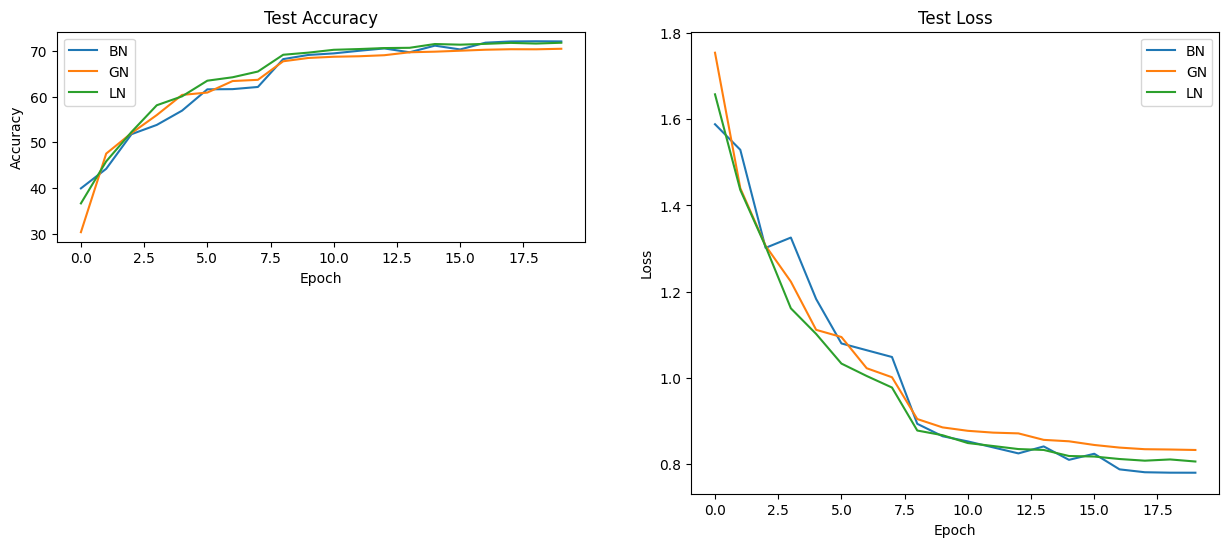

In [ ]:
# fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_acc)
# axs[1, 0].set_title("Training Accuracy")
# axs[0, 1].plot(test_losses)
# axs[0, 1].set_title("Test Loss")
# axs[1, 1].plot(test_acc)
# axs[1, 1].set_title("Test Accuracy")

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

for norm in norm_options:
  train_losses = metrics[norm][0]
  test_losses = metrics[norm][1]
  train_acc = metrics[norm][2]
  test_acc = metrics[norm][3]

  plt.subplot(2,2, 1)

  plt.plot(test_acc)
  plt.legend(norm_options)
  plt.title("Test Accuracy")

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(test_losses)
  plt.legend(norm_options)
  plt.title('Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

--------------- BN --------------- 

--------------- GN --------------- 

--------------- LN --------------- 

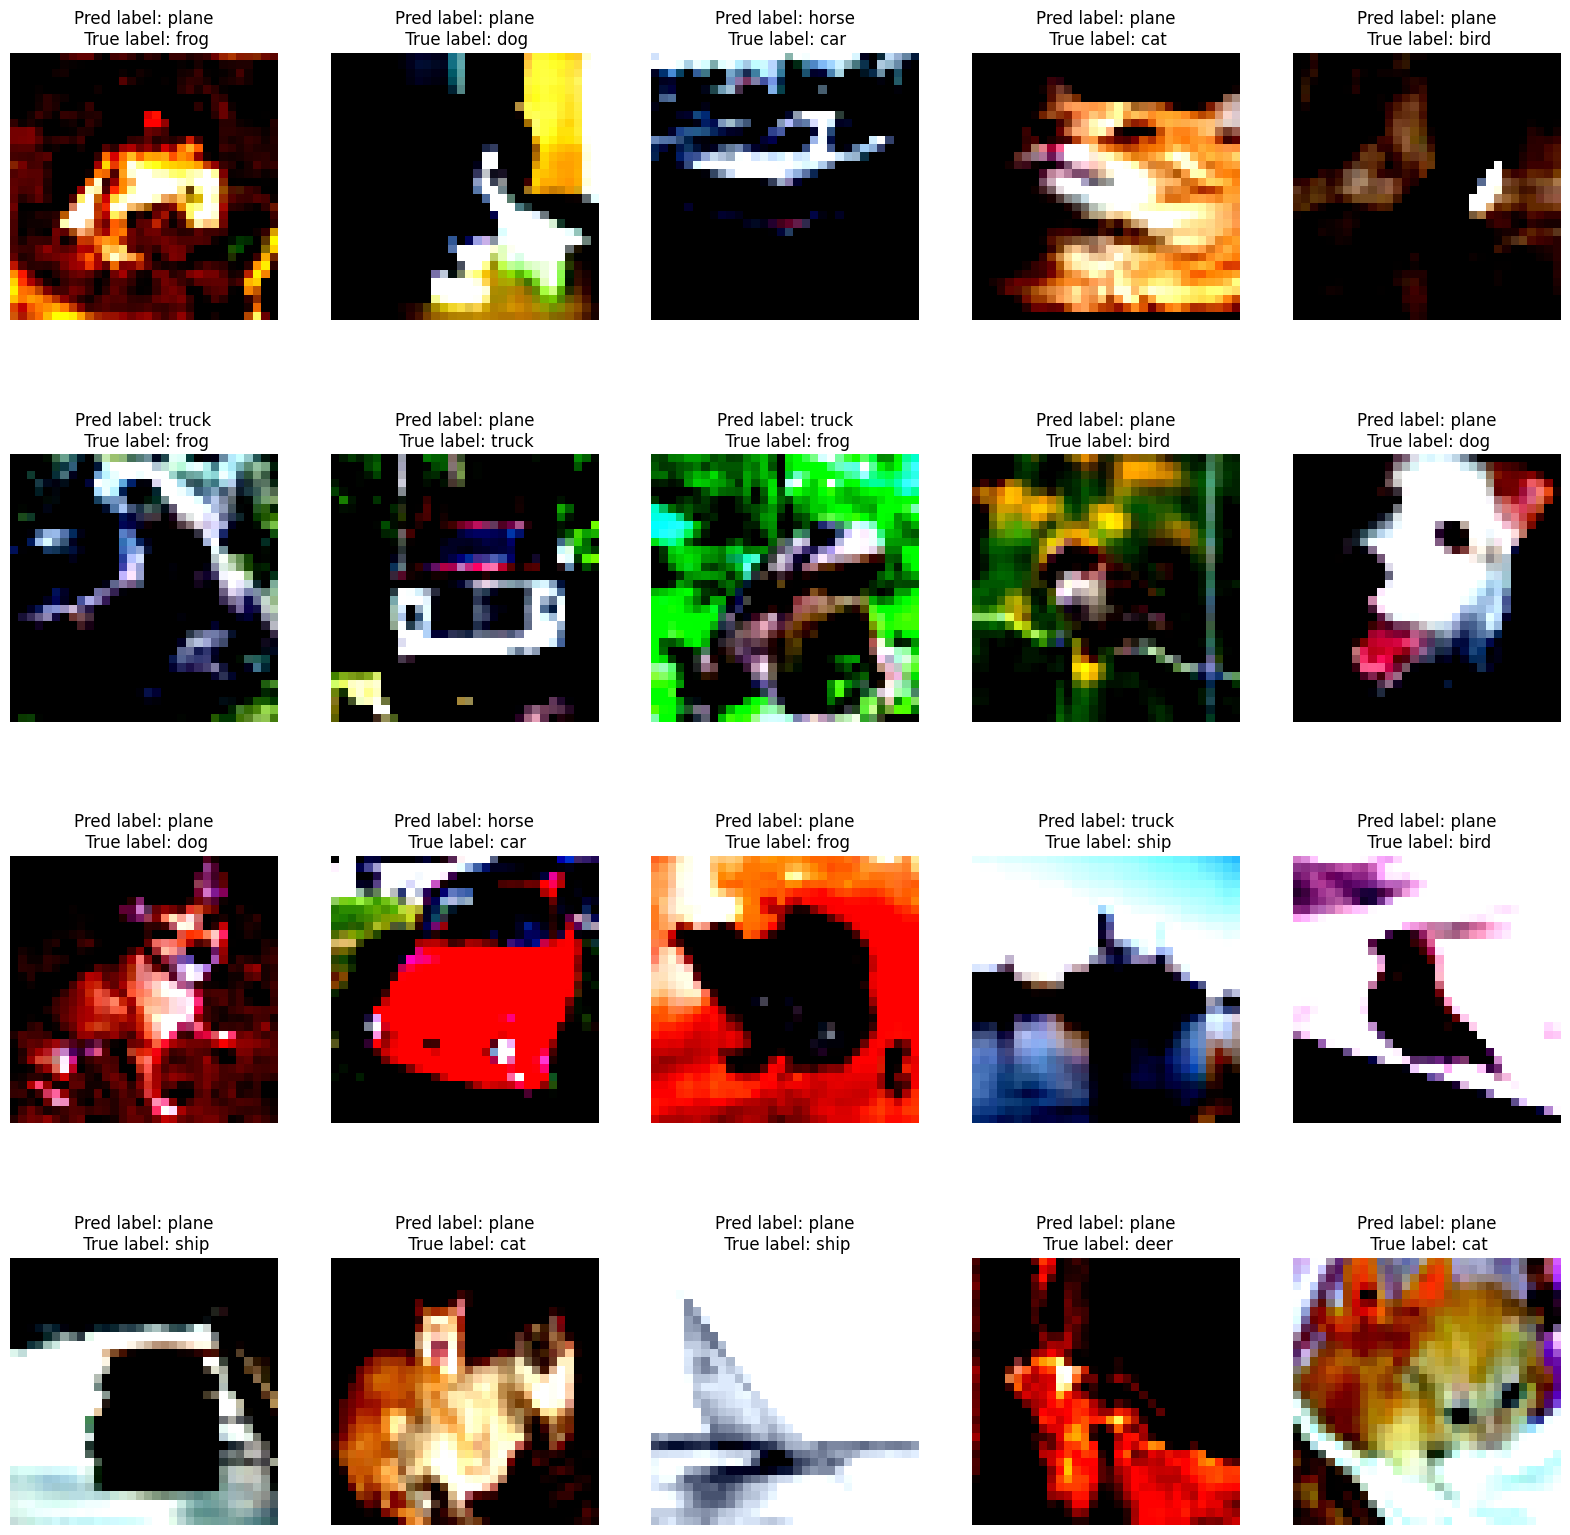

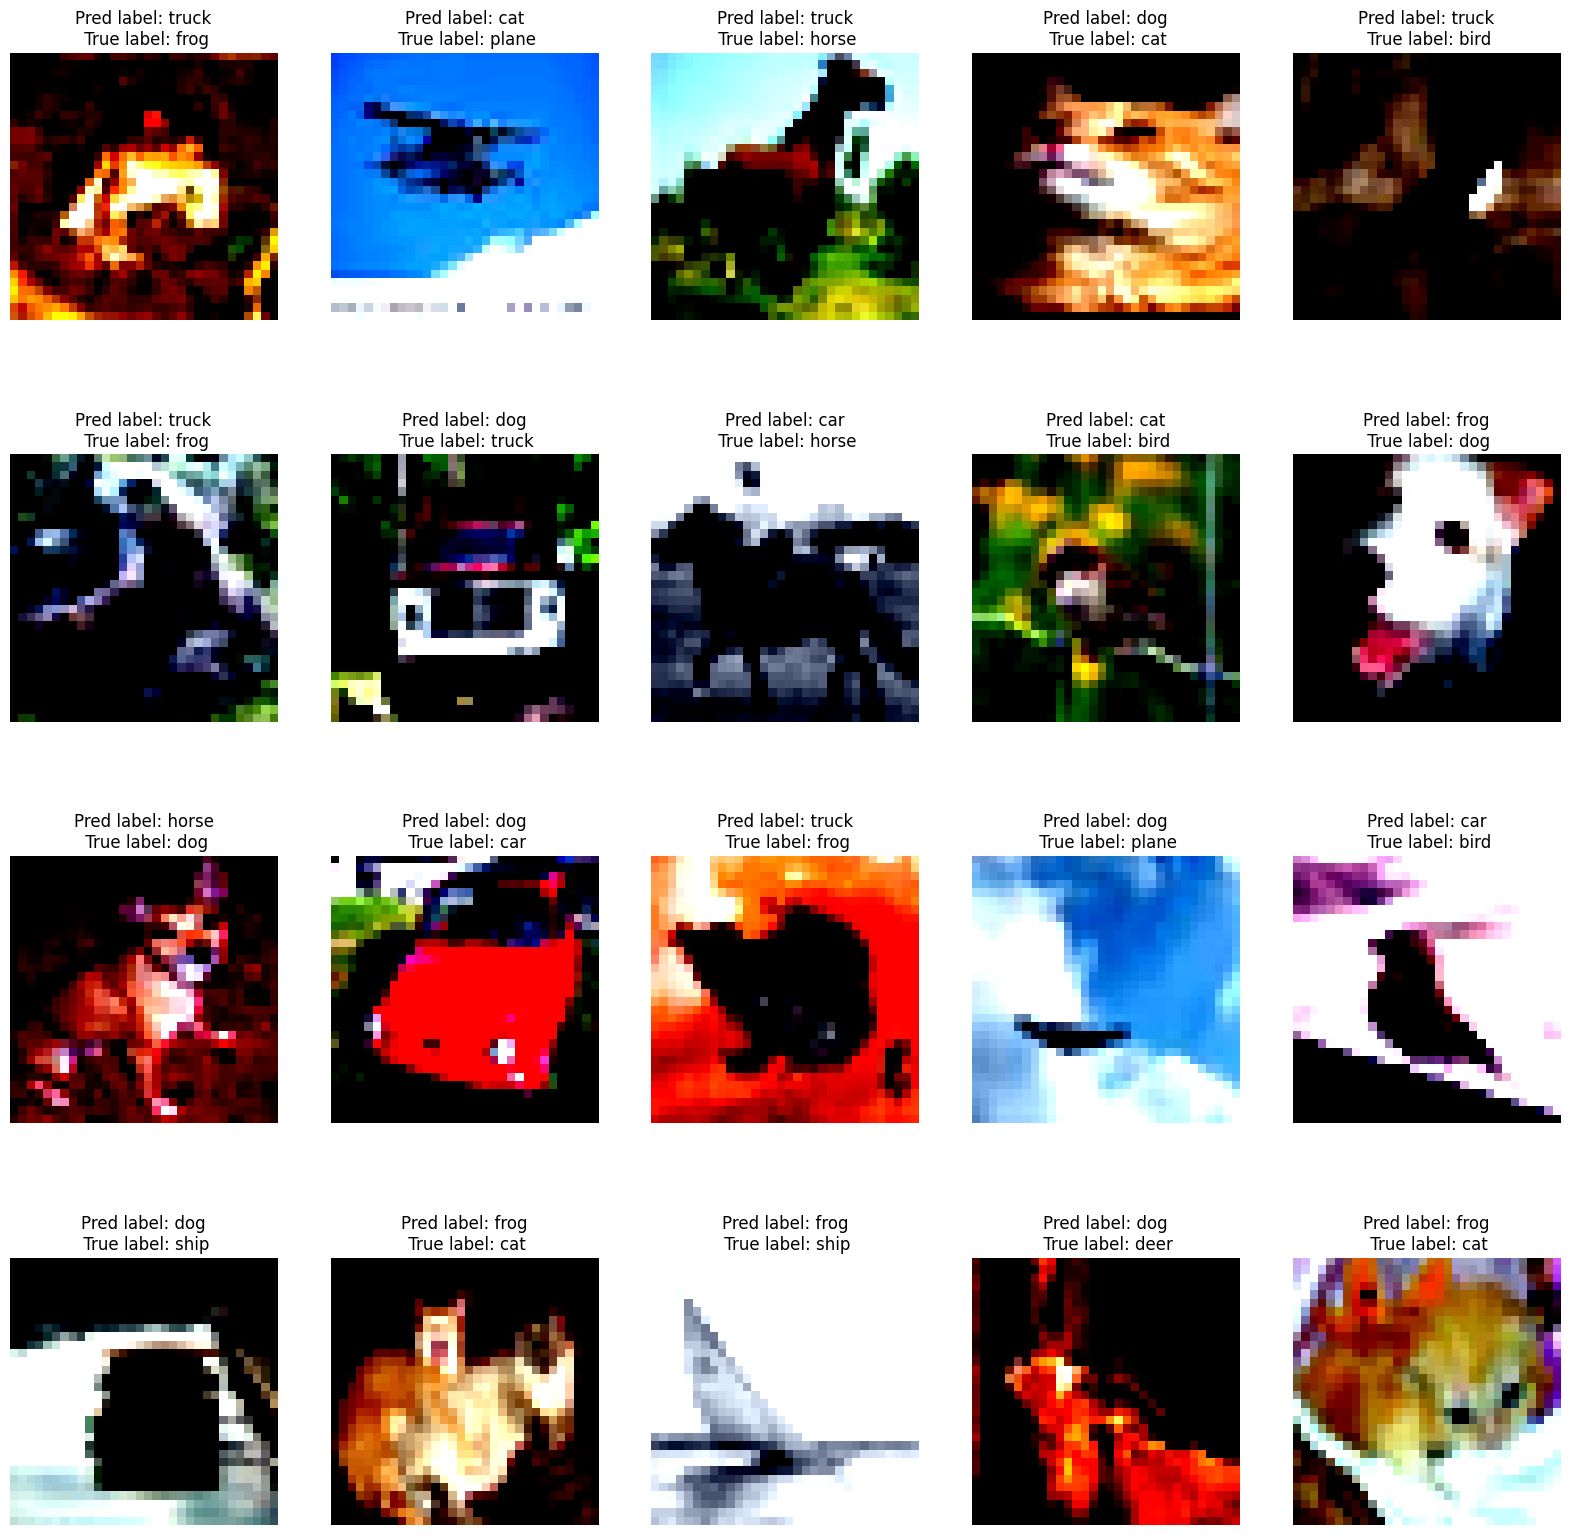

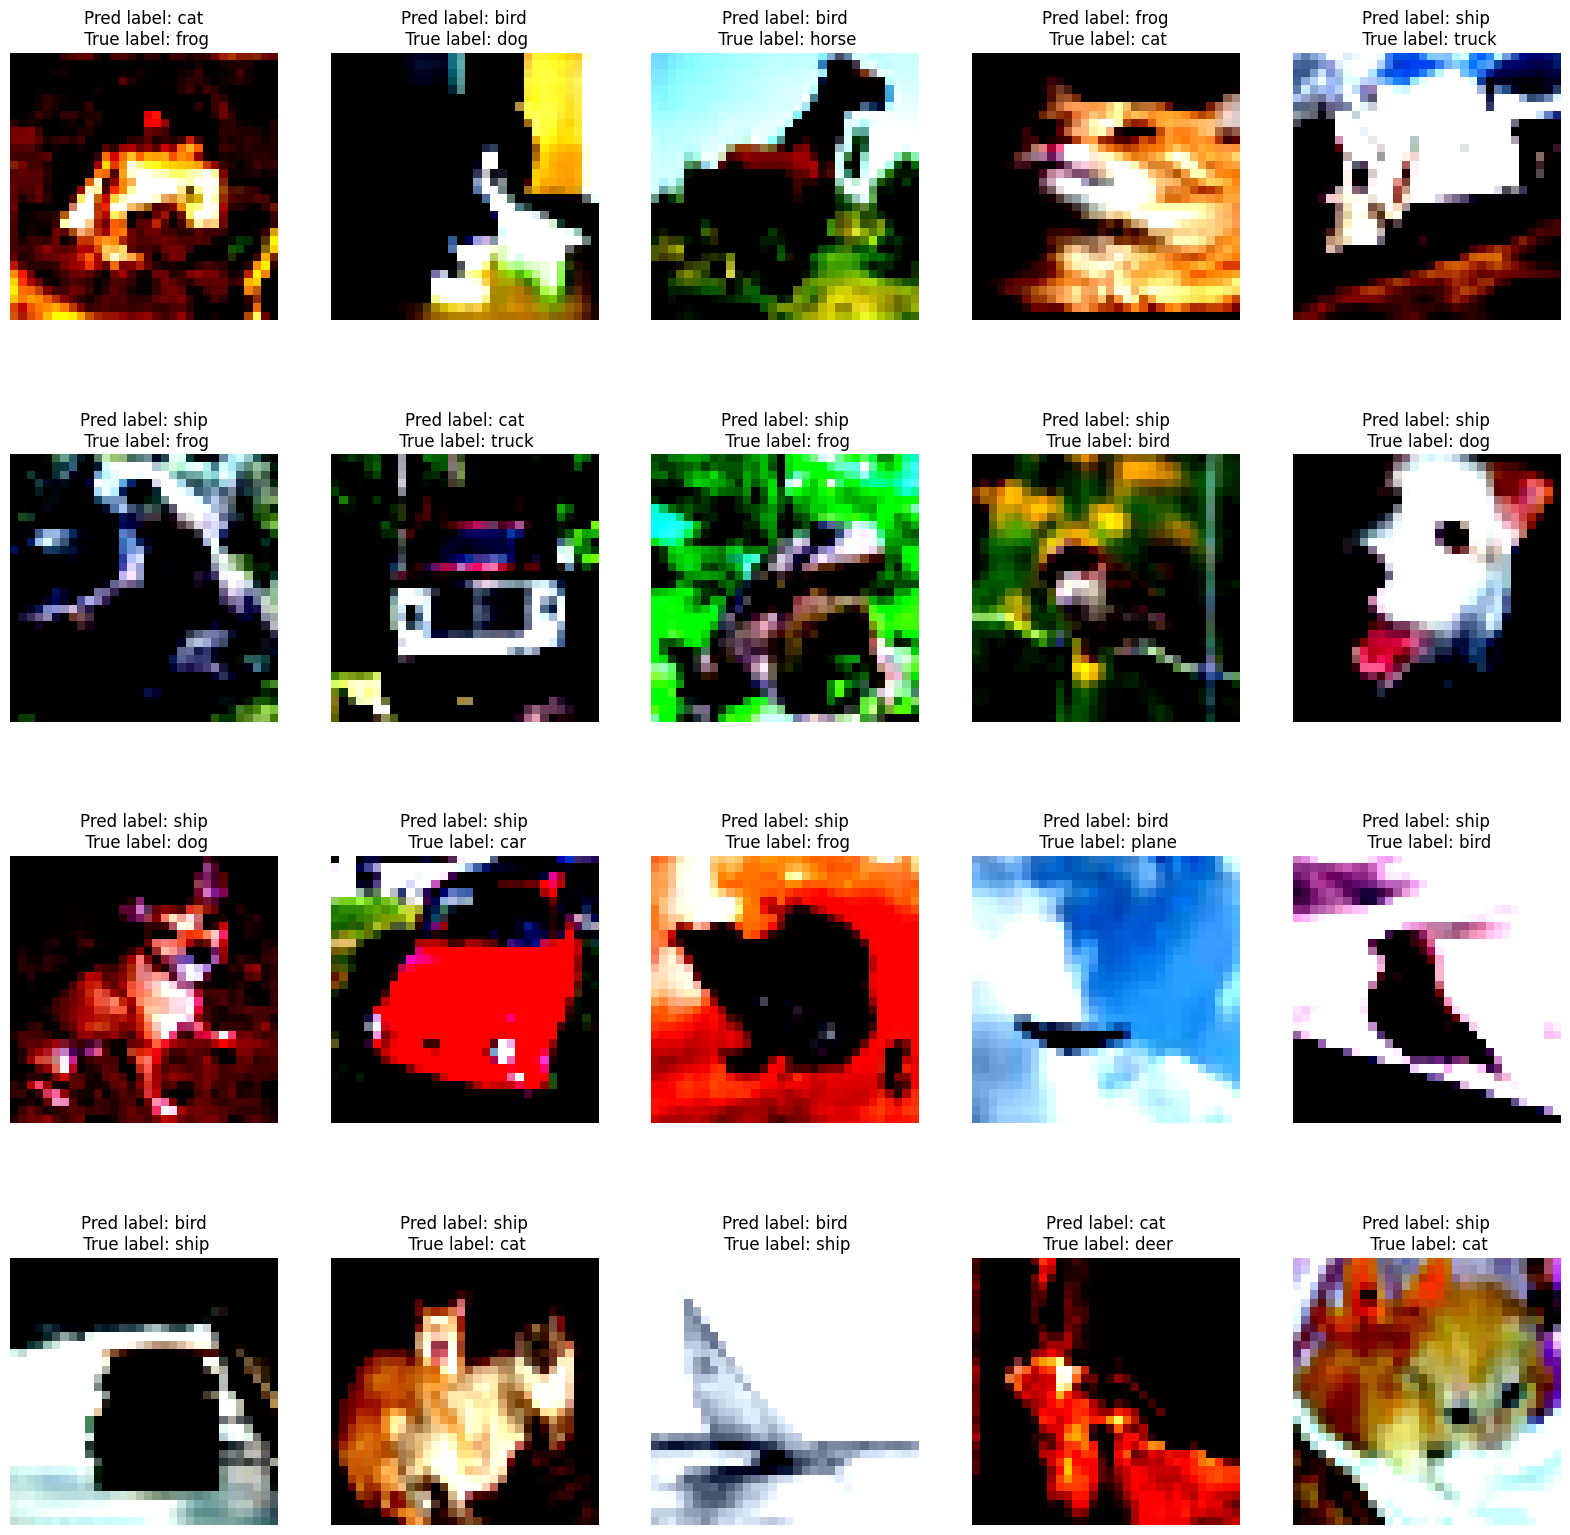

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


for norm in norm_options:

  print('-'*15,end=' ')
  print(norm,end=' ')
  print('-'*15,end = ' ')

  model = Net(norm).to(device)

  model.eval()

  figure = plt.figure(figsize=(20, 20))
  num_of_images = 20
  index = 1

  misclass_img_list = []
  untrans_img=[]

  with torch.no_grad():

      for data, target in testloader:
          data, target = data.to(
              device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)
          act = target.view_as(pred)
          # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
          bool_vec = ~pred.eq(act)

          # now extract the index number from the tensor which has 'true'
          idx = list(
              np.where(bool_vec.cpu().numpy())[0])

          if idx:  # if not a blank list
              idx_list = idx
              # print(data[idx_list[0]].shape)
              if index < num_of_images+1:
                  plt.subplot(4, 5, index)
                  plt.axis('off')
                  a = classes[target[idx[0]].cpu().item()]
                  p = classes[pred[idx[0]].cpu().item()]
                  titl = f"Pred label: {p}\n True label: {a}" # title of plot
                  # prints the 1st index of each batch.

                  img = data[idx[0]].cpu()
                  img = img.squeeze().numpy()
                  untrans_img.append(img)
                  img = np.transpose(img, (1, 2, 0))
                  image = plt.imshow(img, cmap="gray") # showing the plot
                  misclass_img_list.append(image)

                  plt.title(titl)
                  index += 1

array(<matplotlib.image.AxesImage object at 0x7f3c502a2cb0>, dtype=object)